# X-ray lab

# configure kaggle and downloading the NIH dataset

In [ ]:
! pip install kaggle

In [ ]:
! mkdir ~/.kaggle

In [ ]:
! cp kaggle.json ~/.kaggle/

In [ ]:
! chmod 600 ~/.kaggle/kaggle.json

In [ ]:
! kaggle datasets download -d nih-chest-xrays/data --unzip

100% 42.0G/42.0G [13:45<00:00, 68.1MB/s]
100% 42.0G/42.0G [13:45<00:00, 54.6MB/s]


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
# import the necessary packages
import pandas as pd
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
# line magic to included the matplotlib graphs in the notebook, next to the code
%matplotlib inline
import os
import seaborn as sns
sns.set()
import tensorflow as tf
import keras
from keras.applications.densenet import DenseNet121
from keras.models import Model
from keras.layers import Dense, Activation, Flatten, Dropout, BatchNormalization, GlobalAveragePooling2D
from keras.callbacks import ModelCheckpoint, CSVLogger, LearningRateScheduler, ReduceLROnPlateau, EarlyStopping, TensorBoard
from keras.preprocessing import image
from keras.preprocessing.image import ImageDataGenerator
from keras import backend as K
import cv2
import sklearn
from sklearn.metrics import roc_auc_score, roc_curve
import shap
import time
import pickle

Using TensorFlow backend.


# Exploring the dataset

In [ ]:
# read the csv files that contains the training dataset,validation dataset and the testind dataset

train_df = pd.read_csv("/content/drive/MyDrive/GP/dataset/train-all.csv")
valid_df = pd.read_csv("/content/drive/MyDrive/GP/dataset/valid-all.csv")
test_df = pd.read_csv("/content/drive/MyDrive/GP/dataset/test.csv")

# print the dimensions of each data frame

print(f'There are {train_df.shape[0]} rows and {train_df.shape[1]} columns in the training data frame')
print(f'There are {valid_df.shape[0]} rows and {valid_df.shape[1]} columns in the validation data frame')
print(f'There are {test_df.shape[0]} rows and {test_df.shape[1]} columns in the testing data frame')
IMAGE_DIR = "/content/chest_xray"

There are 99316 rows and 16 columns in the training data frame
There are 5672 rows and 16 columns in the validation data frame
There are 420 rows and 16 columns in the testing data frame


In [ ]:
# print the head of training dataframe
train_df.head()

,Image,Atelectasis,Cardiomegaly,Consolidation,Edema,Effusion,Emphysema,Fibrosis,Hernia,Infiltration,Mass,Nodule,PatientId,Pleural_Thickening,Pneumonia,Pneumothorax
0,00008270_015.png,0,0,0,0,0,0,0,0,0,0,0,8270,0,0,0
1,00029855_001.png,1,0,0,0,1,0,0,0,1,0,0,29855,0,0,0
2,00001297_000.png,0,0,0,0,0,0,0,0,0,0,0,1297,1,0,0
3,00012359_002.png,0,0,0,0,0,0,0,0,0,0,0,12359,0,0,0
4,00017951_001.png,0,0,0,0,0,0,0,0,1,0,0,17951,0,0,0


In [ ]:
#check for any null values
train_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 99316 entries, 0 to 99315
Data columns (total 16 columns):
Image                 99316 non-null object
Atelectasis           99316 non-null int64
Cardiomegaly          99316 non-null int64
Consolidation         99316 non-null int64
Edema                 99316 non-null int64
Effusion              99316 non-null int64
Emphysema             99316 non-null int64
Fibrosis              99316 non-null int64
Hernia                99316 non-null int64
Infiltration          99316 non-null int64
Mass                  99316 non-null int64
Nodule                99316 non-null int64
PatientId             99316 non-null int64
Pleural_Thickening    99316 non-null int64
Pneumonia             99316 non-null int64
Pneumothorax          99316 non-null int64
dtypes: int64(15), object(1)
memory usage: 12.1+ MB


In [ ]:
valid_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5672 entries, 0 to 5671
Data columns (total 16 columns):
Image                 5672 non-null object
Atelectasis           5672 non-null int64
Cardiomegaly          5672 non-null int64
Consolidation         5672 non-null int64
Edema                 5672 non-null int64
Effusion              5672 non-null int64
Emphysema             5672 non-null int64
Fibrosis              5672 non-null int64
Hernia                5672 non-null int64
Infiltration          5672 non-null int64
Mass                  5672 non-null int64
Nodule                5672 non-null int64
PatientId             5672 non-null int64
Pleural_Thickening    5672 non-null int64
Pneumonia             5672 non-null int64
Pneumothorax          5672 non-null int64
dtypes: int64(15), object(1)
memory usage: 709.1+ KB


In [ ]:
test_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 420 entries, 0 to 419
Data columns (total 16 columns):
Image                 420 non-null object
PatientId             420 non-null int64
Cardiomegaly          420 non-null int64
Emphysema             420 non-null int64
Effusion              420 non-null int64
Hernia                420 non-null int64
Infiltration          420 non-null int64
Mass                  420 non-null int64
Nodule                420 non-null int64
Atelectasis           420 non-null int64
Pneumothorax          420 non-null int64
Pleural_Thickening    420 non-null int64
Pneumonia             420 non-null int64
Fibrosis              420 non-null int64
Edema                 420 non-null int64
Consolidation         420 non-null int64
dtypes: int64(15), object(1)
memory usage: 52.6+ KB


In [ ]:
# exploring the labels of the dataset 
columns = train_df.keys()
columns = list(columns)
print(columns)

['Image', 'Atelectasis', 'Cardiomegaly', 'Consolidation', 'Edema', 'Effusion', 'Emphysema', 'Fibrosis', 'Hernia', 'Infiltration', 'Mass', 'Nodule', 'PatientId', 'Pleural_Thickening', 'Pneumonia', 'Pneumothorax']


In [ ]:
# Print out the number of positive cases for each pathology class
columns.remove('Image')
columns.remove('PatientId')
print(f"There are {len(columns)} columns of labels for these conditions: {columns}")
for column in columns:
    print(f"The class {column} has {train_df[column].sum()} samples")

There are 14 columns of labels for these conditions: ['Atelectasis', 'Cardiomegaly', 'Consolidation', 'Edema', 'Effusion', 'Emphysema', 'Fibrosis', 'Hernia', 'Infiltration', 'Mass', 'Nodule', 'Pleural_Thickening', 'Pneumonia', 'Pneumothorax']
The class Atelectasis has 10236 samples
The class Cardiomegaly has 2287 samples
The class Consolidation has 3859 samples
The class Edema has 1853 samples
The class Effusion has 11374 samples
The class Emphysema has 2022 samples
The class Fibrosis has 1436 samples
The class Hernia has 109 samples
The class Infiltration has 17130 samples
The class Mass has 4966 samples
The class Nodule has 5546 samples
The class Pleural_Thickening has 2830 samples
The class Pneumonia has 1157 samples
The class Pneumothorax has 4392 samples


In [ ]:
labels = ['Cardiomegaly', 
          'Emphysema', 
          'Effusion', 
          'Hernia', 
          'Infiltration', 
          'Mass', 
          'Nodule', 
          'Atelectasis',
          'Pneumothorax',
          'Pleural_Thickening', 
          'Pneumonia', 
          'Fibrosis', 
          'Edema', 
          'Consolidation']

# checking for Patient Overlap (Data Leakage) in the three datasets

In [ ]:
# takes tow dataset frames "df1" and "df2" and column name which is PatientId
# return true if there is a PatientId in both of the dataset frames arguments
def check_for_leakage(df1, df2, patient_col):
    
    df1_patients_unique = set(df1[patient_col])
    df2_patients_unique = set(df2[patient_col])
    
    patients_in_both_groups = list(df1_patients_unique.intersection(df2_patients_unique))

    leakage = len(patients_in_both_groups) > 0 
    
    return leakage

In [ ]:
print("leakage between train and valid: {}".format(check_for_leakage(train_df, valid_df, 'PatientId')))
print("leakage between train and test: {}".format(check_for_leakage(train_df, test_df, 'PatientId')))
print("leakage between valid and test: {}".format(check_for_leakage(valid_df, test_df, 'PatientId')))

leakage between train and valid: False
leakage between train and test: False
leakage between valid and test: False


# Exploring random images

Display Random 9 Images


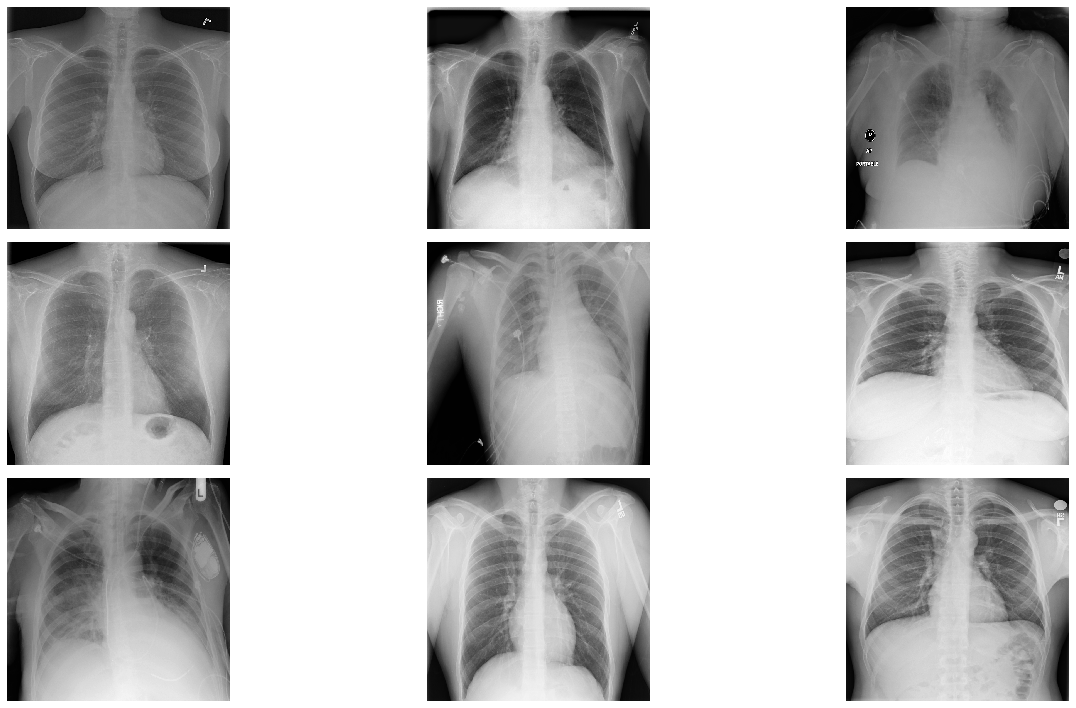

In [ ]:
# display random x-ray images from the dataset

# all the values in the Image column
images = train_df['Image'].values

random_nine_images = [np.random.choice(images) for i in range(9)]

# directory of the dataset
img_dir = '/content/chest_xray'

print('Display Random 9 Images')

# spacify the size of the images
plt.figure(figsize=(20,10))

# Iterate and plot the random images
for i in range(9):
    plt.subplot(3, 3, i + 1)
    img = plt.imread(os.path.join(img_dir, random_nine_images[i]))
    plt.imshow(img, cmap='gray')
    plt.axis('off')
    
# specify the padding between the subplots
plt.tight_layout(pad=1.08)    

The dimensions of the image are 1024 pixels width and 1024 pixels height
The maximum pixel value is 0.9804 and the minimum is 0.0000
The mean value of the pixels is 0.4796 and the standard deviation is 0.2757


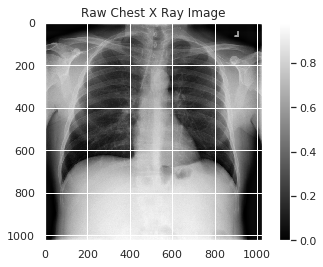

In [ ]:
# print the first image in the dataset with it's details
first_img = train_df.Image[0]
raw_image = plt.imread(os.path.join(img_dir, first_img))
plt.imshow(raw_image, cmap='gray')
plt.colorbar()
plt.title('Raw Chest X Ray Image')
print(f"The dimensions of the image are {raw_image.shape[0]} pixels width and {raw_image.shape[1]} pixels height")
print(f"The maximum pixel value is {raw_image.max():.4f} and the minimum is {raw_image.min():.4f}")
print(f"The mean value of the pixels is {raw_image.mean():.4f} and the standard deviation is {raw_image.std():.4f}")

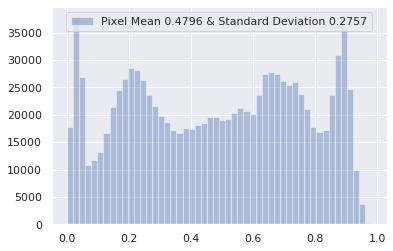

In [ ]:
# Plot a histogram of the distribution of the pixels
sns.distplot(raw_image.ravel(), 
             label=f'Pixel Mean {np.mean(raw_image):.4f} & Standard Deviation {np.std(raw_image):.4f}', kde=False)

plt.legend(loc='upper center')

# preparing the images

In [ ]:
def get_train_generator(df, image_dir, x_col, y_cols, shuffle=True, batch_size=32, seed=1, target_w = 320, target_h = 320):
    
       
    print("getting train generator...") 
    # normalize images
    image_generator = ImageDataGenerator(
        samplewise_center=True,
        samplewise_std_normalization= True)
    
    # flow from directory with specified batch size
    # and target image size
    generator = image_generator.flow_from_dataframe(
            dataframe=df,
            directory=image_dir,
            x_col=x_col,          #I
            y_col=y_cols,
            class_mode="raw",
            batch_size=batch_size,
            shuffle=shuffle,
            seed=seed,
            target_size=(target_w,target_h))
    
    return generator

In [ ]:
def get_test_and_valid_generator(valid_df, test_df, train_df, image_dir, x_col, y_cols, sample_size=100, batch_size=32, 
                                 seed=1, target_w = 320, target_h = 320):
    
    # get generator to sample dataset
    print(f"\nextracting {sample_size} train images to normalize validation and test datasets...")

    raw_train_generator = ImageDataGenerator().flow_from_dataframe(
        dataframe=train_df, 
        directory=IMAGE_DIR, 
        x_col="Image", 
        y_col=labels, 
        class_mode="raw", 
        batch_size=sample_size, 
        shuffle=True, 
        target_size=(target_w, target_h))
    
    # get data sample
    batch = raw_train_generator.next() # generate a batch of samples and associated labels 
    data_sample = batch[0]             # => we need only the sample imgs ie batch[0]

    # use sample to fit mean and std for test set generator
    image_generator = ImageDataGenerator(
        featurewise_center=True,
        featurewise_std_normalization= True)
    
    # fit generator to sample from training data - we use this generator normalizing mean and std using the train sample of 100
    image_generator.fit(data_sample)
    
    print("\ngetting valid generator...")

    # get test generator
    valid_generator = image_generator.flow_from_dataframe(
            dataframe=valid_df,
            directory=image_dir,
            x_col=x_col,
            y_col=y_cols,
            class_mode="raw",
            batch_size=batch_size,
            shuffle=False,
            seed=seed,
            target_size=(target_w,target_h))
    
    print("\ngetting test generator...")
    test_generator = image_generator.flow_from_dataframe(
            dataframe=test_df,
            directory=image_dir,
            x_col=x_col,
            y_col=y_cols,
            class_mode="raw",
            batch_size=batch_size,
            shuffle=False,
            seed=seed,
            target_size=(target_w,target_h))
    return valid_generator, test_generator

In [ ]:
train_generator = get_train_generator(train_df, IMAGE_DIR, "Image", labels)
valid_generator, test_generator= get_test_and_valid_generator(valid_df, test_df, train_df, IMAGE_DIR, "Image", labels)

getting train generator...
Found 99316 validated image filenames.

extracting 100 train images to normalize validation and test datasets...
Found 99316 validated image filenames.

getting valid generator...
Found 5672 validated image filenames.

getting test generator...
Found 420 validated image filenames.


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


The dimensions of the image are 320 pixels width and 320 pixels height
The mean value of the pixels is 0.0000 and the standard deviation is 1.0000


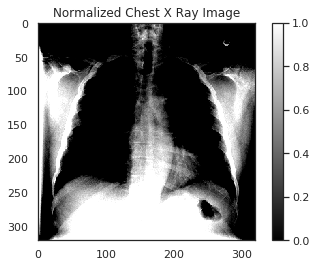

In [ ]:
sns.set_style("white")
x, y = train_generator.__getitem__(0)
plt.imshow(x[0], cmap='gray')
plt.colorbar()
plt.title('Normalized Chest X Ray Image')
print(f"The dimensions of the image are {x.shape[1]} pixels width and {x.shape[2]} pixels height")
print(f"The mean value of the pixels is {x.mean():.4f} and the standard deviation is {x.std():.4f}")

# Class Imbalance & weighted loss function

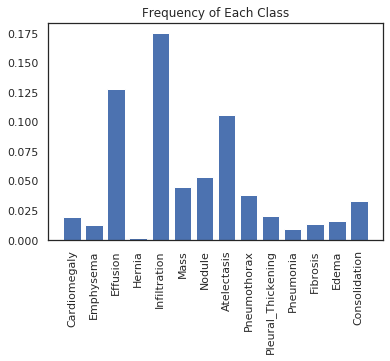

In [ ]:
# Addressing Class Imbalance
plt.xticks(rotation=90)
plt.bar(x=labels, height=np.mean(train_generator.labels, axis=0))
plt.title("Frequency of Each Class")
plt.show()

In [ ]:
# Compute positive and negative frequences for each class
def compute_class_freqs(labels):
    
    N = labels.shape[0]
    
    positive_frequencies = np.sum(labels, axis=0)/N
    negative_frequencies = (N - np.sum(labels, axis=0))/N

    return positive_frequencies, negative_frequencies

In [ ]:
freq_pos, freq_neg = compute_class_freqs(train_generator.labels)
freq_pos

array([0.02 , 0.013, 0.128, 0.002, 0.175, 0.045, 0.054, 0.106, 0.038,
       0.021, 0.01 , 0.014, 0.016, 0.033])

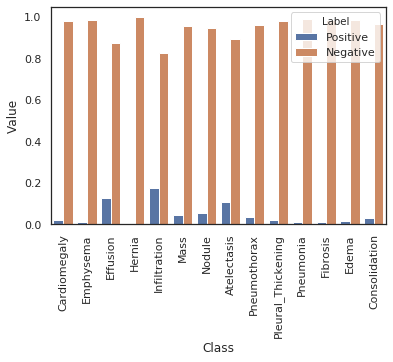

In [ ]:
data = pd.DataFrame({"Class": labels, "Label": "Positive", "Value": freq_pos})
data = data.append([{"Class": labels[l], "Label": "Negative", "Value": v} for l,v in enumerate(freq_neg)], ignore_index=True)
plt.xticks(rotation=90)
f = sns.barplot(x="Class", y="Value", hue="Label" ,data=data)

In [ ]:
pos_weights = freq_neg
neg_weights = freq_pos
pos_contribution = freq_pos * pos_weights 
neg_contribution = freq_neg * neg_weights

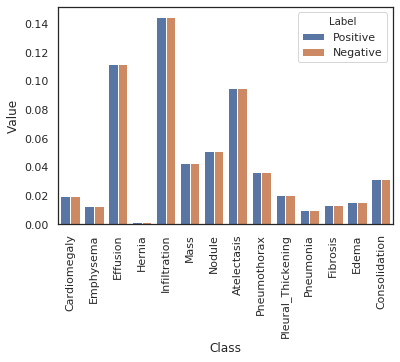

In [ ]:
data = pd.DataFrame({"Class": labels, "Label": "Positive", "Value": pos_contribution})
data = data.append([{"Class": labels[l], "Label": "Negative", "Value": v} 
                        for l,v in enumerate(neg_contribution)], ignore_index=True)
plt.xticks(rotation=90)
sns.barplot(x="Class", y="Value", hue="Label" ,data=data);

In [ ]:
# calculate and return weighted loss function
def get_weighted_loss(pos_weights, neg_weights, epsilon=1e-7):
    
    def weighted_loss(y_true, y_pred):
        
        loss = 0.0
        
        for i in range(len(pos_weights)):
            loss += - pos_weights[i] * K.mean(y_true[:,i] * K.log(y_pred[:,i] + epsilon)) \
            - neg_weights[i] * K.mean((1-y_true[:,i]) * K.log(1-y_pred[:,i] + epsilon))
        return loss
    
    return weighted_loss

# Model Development and Training

In [ ]:
# DenseNet121

# first get the loss weights
class_pos = train_df.loc[:, labels].sum(axis=0)
class_neg = len(train_df) - class_pos
class_total = class_pos + class_neg

pos_weights = class_pos / class_total
neg_weights = class_neg / class_total

# create a base pretrained model
base_model = DenseNet121(weights='/content/drive/MyDrive/GP/dataset/densenet.hdf5', include_top=False)

# add a global spatial average pooling layer
x = base_model.output
x = GlobalAveragePooling2D()(x)

# and a logistic layer
predictions = Dense(len(labels), activation="sigmoid")(x)

model = Model(inputs=base_model.input, outputs=predictions)
model.compile(optimizer='adam', loss=get_weighted_loss(pos_weights, neg_weights))

In [ ]:
model.summary()

Model: "model_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            (None, None, None, 3 0                                            
__________________________________________________________________________________________________
zero_padding2d_1 (ZeroPadding2D (None, None, None, 3 0           input_1[0][0]                    
__________________________________________________________________________________________________
conv1/conv (Conv2D)             (None, None, None, 6 9408        zero_padding2d_1[0][0]           
__________________________________________________________________________________________________
conv1/bn (BatchNormalization)   (None, None, None, 6 256         conv1/conv[0][0]                 
____________________________________________________________________________________________

In [ ]:
# total number of layers
layers_ = model.layers
print('total number of layers =',len(layers_))

total number of layers = 429


In [ ]:
monitor = EarlyStopping(monitor='val_loss', min_delta=1e-3, patience=5, 
        verbose=1, mode='auto', restore_best_weights=True)

history = model.fit_generator(train_generator, 
                              validation_data=valid_generator,
                              steps_per_epoch=100, 
                              validation_steps=25,
                              callbacks=[monitor]
                              epochs = 1000)

Epoch 1/1000
100/100 - 91ss - loss: 1.1940 - val_loss: 1.1126
Epoch 2/1000
100/100 - 91ss - loss: 1.0545 - val_loss: 0.9984
Epoch 3/1000
100/100 - 91ss - loss: 0.9533 - val_loss: 0.9130
Epoch 4/1000
100/100 - 91ss - loss: 0.8823 - val_loss: 0.8365
Epoch 5/1000
100/100 - 90s - loss: 0.8243 - val_loss: 0.7619
Epoch 6/1000
100/100 - 90ss - loss: 0.7592 - val_loss: 0.7059
Epoch 7/1000
100/100 - 90s - loss: 0.7142 - val_loss: 0.6644
Epoch 8/1000
100/100 - 90s - loss: 0.6788 - val_loss: 0.6302
Epoch 9/1000
100/100 - 90s - loss: 0.6481 - val_loss: 0.5979
Epoch 10/1000
100/100 - 90s - loss: 0.6198 - val_loss: 0.5698
Epoch 11/1000
100/100 - 90s - loss: 0.5957 - val_loss: 0.5434
Epoch 12/1000
100/100 - 90s - loss: 0.5738 - val_loss: 0.5189
Epoch 13/1000
100/100 - 90s - loss: 0.5539 - val_loss: 0.4964
Epoch 14/1000
100/100 - 59s - loss: 0.5344 - val_loss: 0.4771
Epoch 15/1000
100/100 - 59s - loss: 0.5177 - val_loss: 0.4601
Epoch 16/1000
100/100 - 59s - loss: 0.5022 - val_loss: 0.4455
Epoch 17/100

# Perdiction and evaluation

In [ ]:
# verdiction and evaluation
predicted_vals = model.predict_generator(test_generator, steps = len(test_generator))
predicted_vals.shape

(420, 14)

In [ ]:
def get_roc_curve(labels, predicted_vals, generator):
    auc_roc_vals = []
    for i in range(len(labels)):
        try:
            gt = generator.labels[:, i]
            pred = predicted_vals[:, i]
            auc_roc = roc_auc_score(gt, pred)
            auc_roc_vals.append(auc_roc)
            fpr_rf, tpr_rf, _ = roc_curve(gt, pred)
            plt.figure(1, figsize=(10, 10))
            plt.plot([0, 1], [0, 1], 'k--')
            plt.plot(fpr_rf, tpr_rf,
                     label=labels[i] + " (" + str(round(auc_roc, 3)) + ")")
            plt.xlabel('False positive rate')
            plt.ylabel('True positive rate')
            plt.title('ROC curve')
            plt.legend(loc='best')
        except:
            print(
                f"Error in generating ROC curve for {labels[i]}. "
                f"Dataset lacks enough examples."
            )
    plt.savefig('ROC.png')
    plt.show()
    return auc_roc_vals

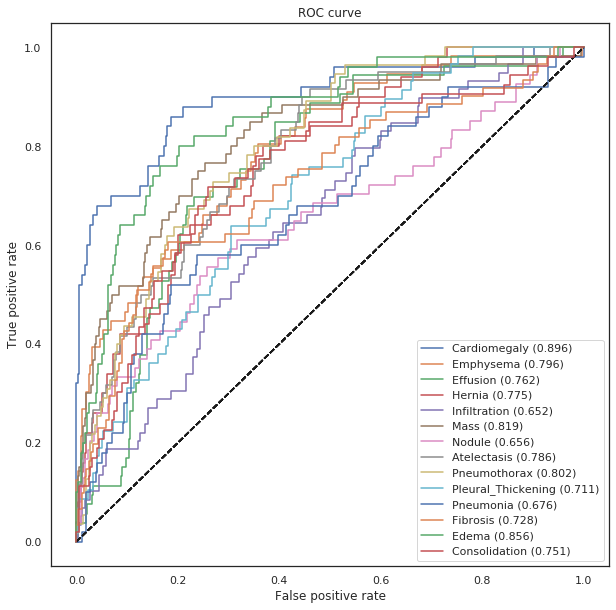

In [ ]:
auc_rocs = get_roc_curve(labels, predicted_vals, test_generator)

In [ ]:
# predictions on a single image and remember to use it later in the integration
sns.reset_defaults()

def get_mean_std_per_batch(df, H=320, W=320):
    sample_data = []
    for idx, img in enumerate(df.sample(100)["Image"].values):
        path = img_dir+'/' + img
        sample_data.append(np.array(image.load_img(path, target_size=(H, W))))

    mean = np.mean(sample_data[0])
    std = np.std(sample_data[0])
    return mean, std    

def load_image_normalize(path, mean, std, H=320, W=320):
    x = image.load_img(path, target_size=(H, W))
    x -= mean
    x /= std
    x = np.expand_dims(x, axis=0)
    return x

In [ ]:
mean, std = get_mean_std_per_batch(train_df)
print(mean,std)
im_path = img_dir + '/00010475_020.png'
processed_image = load_image_normalize(im_path, mean, std)
preds = model.predict(processed_image)
pred_df = pd.DataFrame(preds, columns = labels)
pred_df


127.38619140625 55.403634110083324


,Cardiomegaly,Emphysema,Effusion,Hernia,Infiltration,Mass,Nodule,Atelectasis,Pneumothorax,Pleural_Thickening,Pneumonia,Fibrosis,Edema,Consolidation
0,0.561372,0.147697,0.898682,0.05301,0.647338,0.240942,0.099964,0.791807,0.154705,0.178645,0.522276,0.021567,0.685058,0.866234


In [ ]:
model.save('xrayl_model.h5')